In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# import the dataset 
# load in the Excel file
file_path = "Shloshim.xlsx"
data = pd.ExcelFile(file_path)

# turn into a dataframe and load in the first few rows
sheet_names = data.sheet_names
df = data.parse('Sheet1')
df.columns, df.head()

# rename the columns for easier access
df.rename(columns={
    'Date': 'Date',
    'NVDA UW Equity - Last Price': 'NVDA',
    'AMD UW Equity - Last Price': 'AMD'
}, inplace=True)
# convert the date column to datetime for time series analysis 
df['Date'] = pd.to_datetime(df['Date'])
# df.set_index('Date', inplace=True)  # optional: makes Date the index

In [3]:
# cleaning the dataset 

# first we check for the missing values 
# Check for missing values in each column
missing_values = df.isnull().sum()
missing_values

# since there is only one missing row, then interpolate
df.interpolate(method='linear', inplace=True)

# confirming that missing values are handled
missing_2 = df.isnull().sum()
missing_2

Date    0
NVDA    0
AMD     0
dtype: int64

In [4]:
# normalise prices to compare relative change in values 
# min-max normalisation based on first row
df['NVDA_norm'] = df['NVDA'] / df['NVDA'].iloc[0]
df['AMD_norm'] = df['AMD'] / df['AMD'].iloc[0]

# Kalman Filter for pairs trading assumes the spread is stationary 
# calculate the spread then apply the ADF test.
from statsmodels.tsa.stattools import adfuller

spread = df['NVDA_norm'] - df['AMD_norm']  

adf_result = adfuller(spread)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -2.6151991756461994
p-value: 0.08989641964394851


In [5]:
# the p value for the last normalisation was > 0.05 so we reject null hypothesis 
# we try log prices instead of normal ones 
df['log_NVDA'] = np.log(df['NVDA'])
df['log_AMD'] = np.log(df['AMD'])
spread2 = df['log_NVDA'] - df['log_AMD']

adf_result2 = adfuller(spread2)
print("ADF Statistic:", adf_result2[0])
print("p-value:", adf_result2[1])

# p values < 0.05 so we accept null hypothesis 

ADF Statistic: -2.1808711435675416
p-value: 0.21326123176653594


In [6]:
# computing the intitial hedge ratio

# define the two price series
X = df['AMD']
Y = df['NVDA']

# adding constant to X for the intercept term
X_with_const = sm.add_constant(X)

# fit the Ordinary Least Square model
ols_model = sm.OLS(Y, X_with_const).fit()

# get hedge ratio and intercept
hedge_ratio = ols_model.params[1]
intercept = ols_model.params[0]

hedge_ratio, intercept

/tmp/ipykernel_54/3627235897.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hedge_ratio = ols_model.params[1]
/tmp/ipykernel_54/3627235897.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = ols_model.params[0]


(0.8726536805922656, -49.38903276473584)

In [7]:
# 4.2. implementing Kalman Filter

# get numpy arrays for calculation
x = df['AMD'].values
y = df['NVDA'].values
n = len(x)

# intialise Kalman filter parameters
beta = np.zeros(n)
P = np.zeros(n)
Q = 0.001 # provess noise covariance
R = 1 # observing noise covariance

# the initial guesses
beta[0] = 0
P[0] = 1

# Kalman Filter Iteration
for t in range(1, n):
    # prediction
    # assuming hedge ratio follows random walk
    beta_pred = beta[t-1]
    P_pred = P[t-1] + Q
    # Update
    # K = Kalman Gain (how much weight to give the new obser vs predic)
    K = P_pred * x[t] / (x[t]**2 * P_pred + R)
    beta[t] = beta_pred + K * (y[t] - beta_pred * x[t])
    P[t] = (1 - K * x[t]) * P_pred

# computing dynamic spread
spread_kalman = y - beta * x

# ADF test on the dynamic spread
adf_result_kalman = adfuller(spread_kalman)
adf_stat_kalman = adf_result_kalman[0]
p_val_kalman = adf_result_kalman[1]

(adf_stat_kalman, p_val_kalman)


(-8.25083610828318, 5.396619062243376e-13)

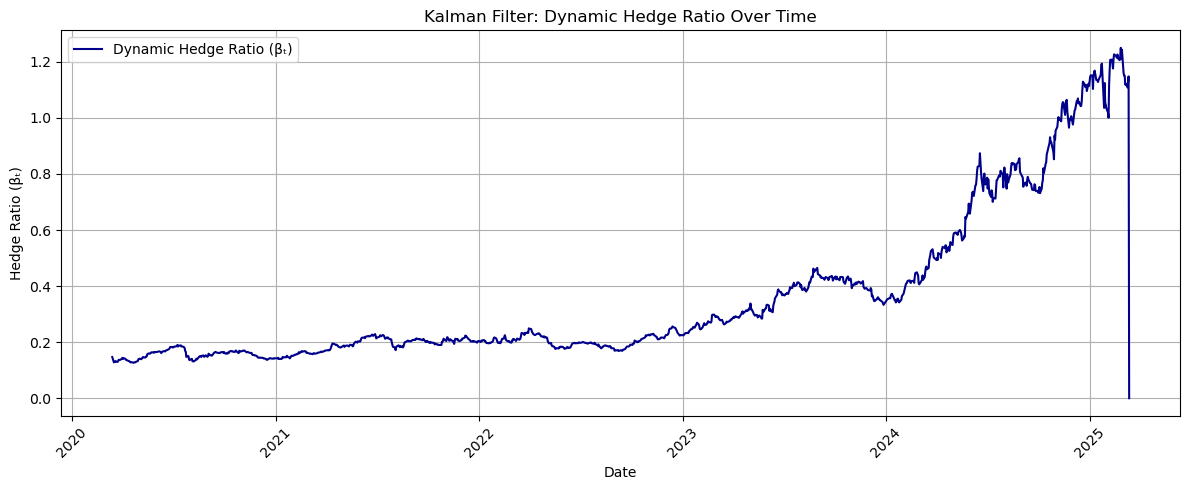

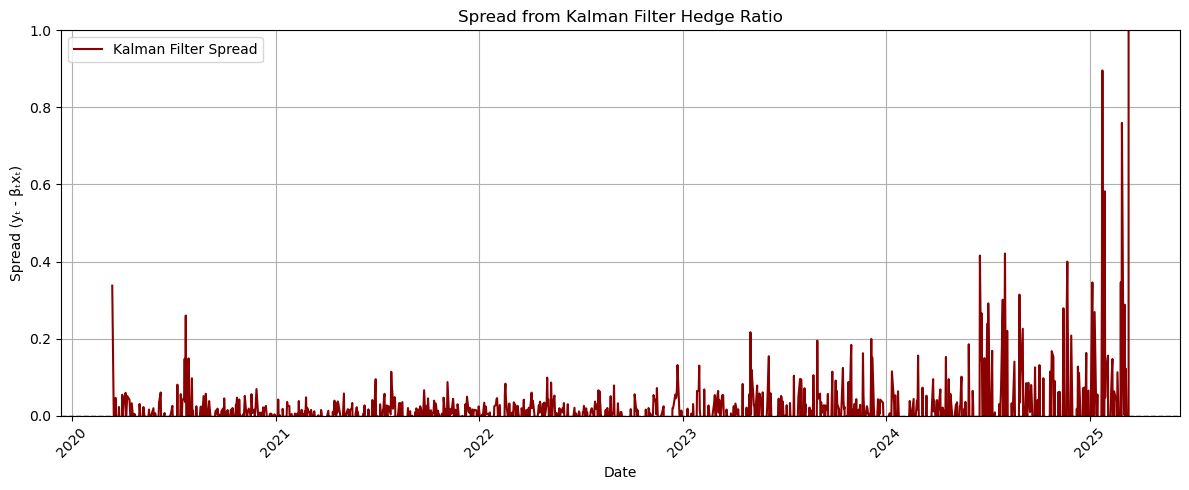

In [8]:
# visualising Kalman Filter

# plot for the dynamic hedge ratio over time
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], beta, label='Dynamic Hedge Ratio (βₜ)', color='darkblue')
plt.title('Kalman Filter: Dynamic Hedge Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Hedge Ratio (βₜ)')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# plot for the Kalman spread
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], spread_kalman, label='Kalman Filter Spread', color='darkred')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('Spread from Kalman Filter Hedge Ratio')
plt.xlabel('Date')
plt.ylabel('Spread (yₜ - βₜxₜ)')
# plt.xlim(0,2025)
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
# 4.3. calculating the spread

# using the dynamic hedge ratio
spread_kalman = y - beta * x
# first few values of the spread
spread_kalman[:5]


array([ 1.15580000e+02,  1.13807741e-02, -2.07488819e-01, -1.63706242e-01,
        1.21712797e-01])

In [10]:
# 5.implement trading strategy 

# 5.1. calculate z score of the spread 
mean_spread = np.mean(spread_kalman)
std_spread = np.std(spread_kalman)
# Z-score calculation
z_score = (spread_kalman - mean_spread) / std_spread

# 5.2. generating trading signals based on Z-score thresholds
# create zero signals first 
signals = np.zeros_like(z_score)

# trading logic and rules

# Long signal: Z < -1
signals[z_score < -1] = 1
# Short signal: Z > 1
signals[z_score > 1] = -1
# Exit signal: when Z moves back toward 0 (inside -0.5 to 0.5 range)
signals[np.abs(z_score) < 0.5] = 0

# first few signals
signals[:10]

array([-1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

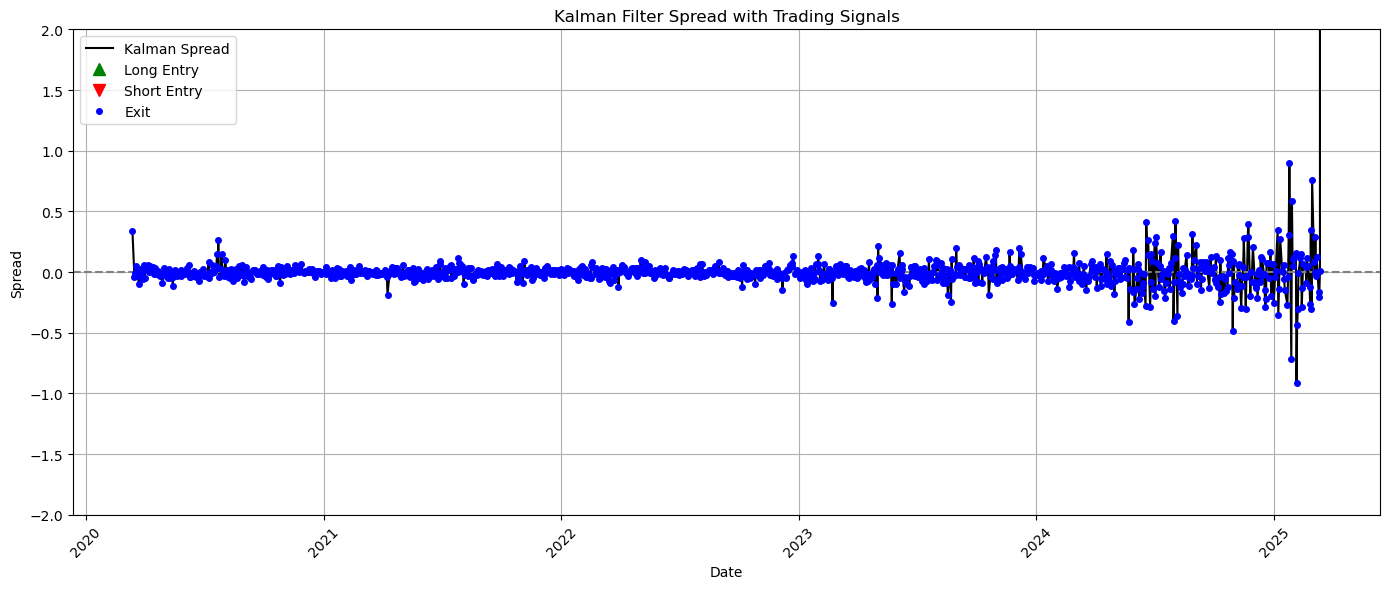

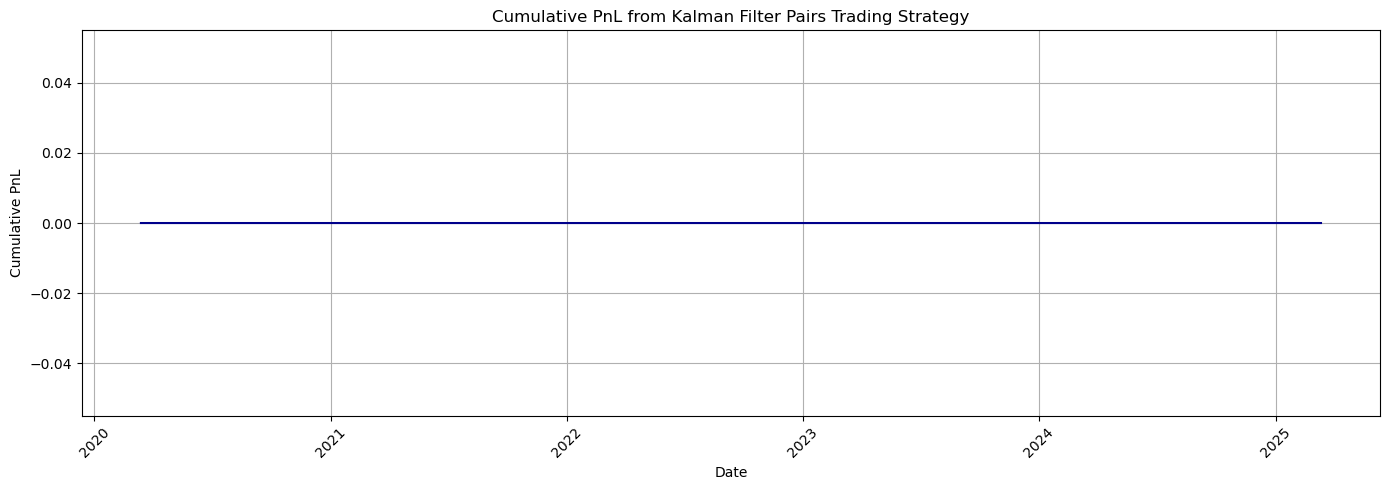

In [11]:
# Create a signal-shifted position to simulate holding
positions = np.zeros_like(signals)
for t in range(1, len(signals)):
    if signals[t] != 0:
        positions[t] = signals[t]
    else:
        positions[t] = positions[t - 1]  # hold previous position

# Plot the spread and signals
plt.figure(figsize=(14, 6))
plt.plot(df['Date'], spread_kalman, label='Kalman Spread', color='black')
plt.axhline(0, color='gray', linestyle='--')

# Mark long entries
plt.plot(df['Date'][signals == 1], spread_kalman[signals == 1], '^', markersize=8, color='green', label='Long Entry')
# Mark short entries
plt.plot(df['Date'][signals == -1], spread_kalman[signals == -1], 'v', markersize=8, color='red', label='Short Entry')
# Mark exits
plt.plot(df['Date'][np.abs(z_score) < 0.5], spread_kalman[np.abs(z_score) < 0.5], 'o', markersize=4, color='blue', label='Exit')

plt.title('Kalman Filter Spread with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.ylim(-2,2)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Simulate PnL (basic) ---
# Daily return from spread change * previous position
spread_returns = np.diff(spread_kalman)
pnl = positions[:-1] * (-spread_returns)  # Short = profit when spread falls

# Cumulative PnL
cumulative_pnl = np.cumsum(pnl)

# Plot cumulative PnL
plt.figure(figsize=(14, 5))
plt.plot(df['Date'][1:], cumulative_pnl, color='darkblue')
plt.title('Cumulative PnL from Kalman Filter Pairs Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
